In [1]:
# prompt: Download this kaggle database: https://www.kaggle.com/datasets/sebastiantarebustos/scrapped-chilean-news-articles-from-biobiochile
!pip install kaggle

In [4]:
!mv kaggle.json ~/.kaggle/

In [5]:
!kaggle datasets download -d sebastiantarebustos/scrapped-chilean-news-articles-from-biobiochile

 93% 14.0M/15.0M [00:01<00:00, 11.2MB/s]
100% 15.0M/15.0M [00:01<00:00, 7.88MB/s]


In [6]:
!unzip scrapped-chilean-news-articles-from-biobiochile.zip

Archive:  scrapped-chilean-news-articles-from-biobiochile.zip
  inflating: article_202310072058.csv  


In [7]:
!ls

article_202310072058.csv  sample_data  scrapped-chilean-news-articles-from-biobiochile.zip


In [8]:
# prompt: install torch and transformers for gpu for fine tuning a huggingface model

!pip install torch torchvision torchaudio --extra-index-url https://download.pytorch.org/whl/cu116
!pip install transformers


Looking in indexes: https://pypi.org/simple, https://download.pytorch.org/whl/cu116


In [9]:
!pip install pyspellchecker

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 40.9 MB/s eta 0:00:00


In [10]:
!pip install absl-py nltk six>=1.14
!pip install rouge-score

  Preparing metadata (setup.py) ... done
  Created wheel for rouge-score: filename=rouge_score-0.1.2-py3-none-any.whl size=24933 sha256=a24acb37129caeb63e19839859093d1c3d22f8572cfd036ed7635c3d7792d725
  Stored in directory: /root/.cache/pip/wheels/5f/dd/89/461065a73be61a532ff8599a28e9beef17985c9e9c31e541b4
Successfully built rouge-score


In [11]:
import pandas as pd
import torch
from transformers import BertTokenizerFast, EncoderDecoderModel
import numpy as np

In [12]:
from spellchecker import SpellChecker

spell = SpellChecker(language='es')

def checkDict(word):
    return word in spell

In [13]:
import nltk
from nltk.metrics.distance import edit_distance

nltk.download('punkt')  # Download necessary NLTK data

def most_similar_word(target_word, text):
    words = nltk.word_tokenize(text)
    most_similar = None
    min_distance = float('inf')

    for word in words:
        distance = edit_distance(target_word, word)
        if distance < min_distance:
            min_distance = distance
            most_similar = word
    return most_similar

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [14]:
def evaluateModel(reference, summaries):
    from rouge_score import rouge_scorer
    rouge = rouge_scorer.RougeScorer(['rouge1', 'rougeL'], use_stemmer=True)
    scores = []
    for i in range(len(summaries)):
        score = rouge.score(reference[i], summaries[i])
        scores.append(score)
    return scores
def printScores(scores):
    chunk=0
    for s in scores:
        chunk=chunk+1
        print('Chunk ', chunk)
        r1 = s['rouge1']
        print('scores:\t precision \t recall \t fmeasure')
        print(f'rouge1:\t {r1.precision:.5f} \t {r1.recall:.5f} \t {r1.fmeasure:.5f}')
        r2 = s['rougeL']
        print(f'rougeL:\t {r2.precision:.5f} \t {r2.recall:.5f} \t {r2.fmeasure:.5f}\n')

In [15]:
df = pd.read_csv("article_202310072058.csv", sep=";")

In [16]:
df['publish_date'] = pd.to_datetime(df['publish_date'])
df.head()

,article_hash,article_title,category,publish_date,article_body,raw_content,source_entity,article_link,generated_summary,negative_score,importance_score
0,cfca211bf39221671436397b140ea57a7a9268851dfef8...,Solicitan la caducidad de 166 concesiones acuí...,Nacional,2023-07-17 23:54:00,La región de Los Lagos es una de las regiones ...,\n \n\n ...,biobiochile.cl,https://www.biobiochile.cl/noticias/nacional/r...,NaN,NaN,NaN
1,de051d5444e79470f618b38588ea5988ce808ee1db192d...,Lota: Bomberos descarta que auto estacionado e...,Nacional,2023-07-17 23:10:00,Una camioneta se estacionó justo a la salida d...,\n \n\n ...,biobiochile.cl,https://www.biobiochile.cl/noticias/nacional/r...,NaN,NaN,NaN
2,39dff9b324fe3fb40b70d8a25651e95d57e015ea274865...,Declaran emergencia ambiental para este martes...,Nacional,2023-07-17 23:02:00,La Delegación presidencial declaró emergencia ...,\n \n\n ...,biobiochile.cl,https://www.biobiochile.cl/noticias/nacional/r...,NaN,NaN,NaN
3,f4001720cfe06f5c0aa36c3d8b83bd25a2b8bad50e14c4...,Estudio revela preocupante aumento de tercera ...,Nacional,2023-07-17 21:58:00,Una de las razones de este aumento podría ser ...,\n \n\n ...,biobiochile.cl,https://www.biobiochile.cl/noticias/nacional/r...,NaN,NaN,NaN
4,8212613c7830f1466362f2dfc412c5675cde6376b752df...,"Denuncia de ""malos olores"": Municipalidad de Q...",Nacional,2023-07-17 21:18:00,La Municipalidad de Quilicura reportó la noche...,\n \n\n ...,biobiochile.cl,https://www.biobiochile.cl/noticias/nacional/r...,NaN,NaN,NaN


In [17]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
ckpt = 'mrm8488/bert2bert_shared-spanish-finetuned-summarization'
tokenizer = BertTokenizerFast.from_pretrained(ckpt)
model = EncoderDecoderModel.from_pretrained(ckpt).to(device)

tokenizer_config.json:   0%|          | 0.00/520 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/242k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/4.51k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/555M [00:00<?, ?B/s]

The following encoder weights were not tied to the decoder ['bert/pooler']
The following encoder weights were not tied to the decoder ['bert/pooler']
The following encoder weights were not tied to the decoder ['bert/pooler']
The following encoder weights were not tied to the decoder ['bert/pooler']


In [18]:
device

'cuda'

In [19]:
def generate_summary(text, max_output_length=80, min_output_length=10):
    inputs = tokenizer([text], padding="max_length", truncation=True, max_length=512, return_tensors="pt")
    input_ids = inputs.input_ids.to(device)
    attention_mask = inputs.attention_mask.to(device)

    # Set max_length and min_length parameters for shorter summaries
    output = model.generate(
        input_ids,
        attention_mask=attention_mask,
        length_penalty=0.6,
        no_repeat_ngram_size=2
    )

    return tokenizer.decode(output[0], skip_special_tokens=True)

In [20]:
def getChunks(article):
    parts = article.split('.')
    df = pd.DataFrame(parts)
    df.columns = ['article_parts']
    df = df[df['article_parts'].str.len() > 0]
    return df.to_numpy().squeeze()

In [21]:
def mergeChunks(number, chunks):
    # Merge the chunks into workable lengths ~390
    # The purpose of this is to generate shorter summaries of about 3~4 bulletpoints
    results = []
    acc = []
    try:
        for c in chunks:
            txt = c.strip()
            if (len('. '.join(acc)) + len(txt)) >= number:
                results.append('. '.join(acc.copy()))
                acc.clear()
            acc.append(txt)
        if acc:
            results.append('. '.join(acc))
    except Exception as e:
        print(e)
    return results

<Axes: >

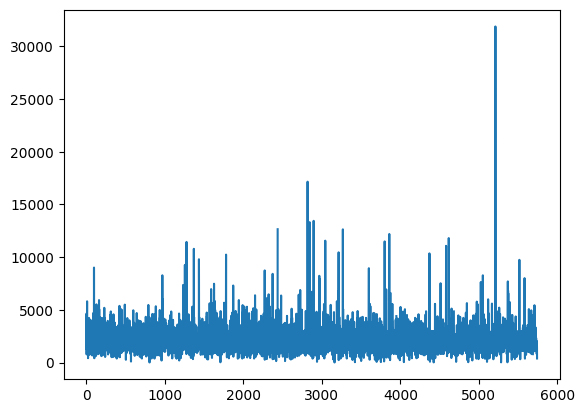

In [22]:
# Remove Outliers
body_len = df['article_body'].str.len()
body_len.plot()

In [23]:
df['article_body'].str.len().describe()

count     5687.000000
mean      2141.645331
std       1236.157108
min         15.000000
25%       1433.000000
50%       1930.000000
75%       2582.000000
max      31870.000000
Name: article_body, dtype: float64

In [24]:
# ~200 extreme values
len(df[df['article_body'].str.len() < 500]), len(df[df['article_body'].str.len() > 5000])

(109, 112)

In [25]:
# Remove outliers
df = df[(df['article_body'].str.len() >= 500) & (df['article_body'].str.len() <= 5000)]

**Quick Test**

In [26]:
article = df.sample(1)
print('Article Length:', int(article['article_body'].str.len()))
print('Title:', article['article_title'].values[0])
print('Body:', article['article_body'].values[0])
article_body = article['article_body'].values[0]
print('Optimal length: ~', int(len(article_body)/390), 'chunks') # About 390 length recommended for summarizer
print(article_body)

Article Length: 3459
Title: Acusan a RN y Evópoli de "dañar" Comisión para la Paz tras enmienda de consejeros constitucionales
Body: La diputada socialista Emilia Nuyado y el senador Francisco Huenchumilla (DC) acusaron que partidos de oposición, a través de un enmienda presentada en el Consejo Constitucional, busca dañar la Comisión para la Paz y el Entendimiento. Nacional La diputada Emilia Nuyado (PS) y el senador Francisco Huenchumilla (DC) acusaron que la derecha busca dañar la Comisión para la Paz y el Entendimiento -de la que son integrantes- al ingresar una enmienda de disposición transitoria en el proyecto de nueva Constitución. En específico, se trata de la iniciativa que contempla la creación de una Comisión de Reparación y Buena Convivencia. Por un lado, según acusó la socialista, dicha propuesta tiene “un enfoque contrario a lo que el pueblo nación mapuche ha exigido según su cosmovisión”. La enmienda transitoria 14 presentada por los consejeros Germán Becker (RN), Pilar C

In [27]:
chunks = getChunks(article_body)
print('Total chunks: \t\t', len(chunks))
merged_chunks = mergeChunks(390, chunks)
print('Optimal chunks: \t', f'{(len(article_body)/(390)):0.2f}')
print('Result chunks: \t\t', len(merged_chunks))
merged_chunks[0]

Total chunks: 		 18
Optimal chunks: 	 8.87
Result chunks: 		 14


'La diputada socialista Emilia Nuyado y el senador Francisco Huenchumilla (DC) acusaron que partidos de oposición, a través de un enmienda presentada en el Consejo Constitucional, busca dañar la Comisión para la Paz y el Entendimiento'

In [28]:
for i in range(len(merged_chunks)):
    merged_chunks[i] = merged_chunks[i] + '.'
    merged_chunks[i] = merged_chunks[i].strip()

In [29]:
merged_chunks[0]

'La diputada socialista Emilia Nuyado y el senador Francisco Huenchumilla (DC) acusaron que partidos de oposición, a través de un enmienda presentada en el Consejo Constitucional, busca dañar la Comisión para la Paz y el Entendimiento.'

In [30]:
merged_chunks

['La diputada socialista Emilia Nuyado y el senador Francisco Huenchumilla (DC) acusaron que partidos de oposición, a través de un enmienda presentada en el Consejo Constitucional, busca dañar la Comisión para la Paz y el Entendimiento.',
 'Nacional La diputada Emilia Nuyado (PS) y el senador Francisco Huenchumilla (DC) acusaron que la derecha busca dañar la Comisión para la Paz y el Entendimiento -de la que son integrantes- al ingresar una enmienda de disposición transitoria en el proyecto de nueva Constitución.',
 'En específico, se trata de la iniciativa que contempla la creación de una Comisión de Reparación y Buena Convivencia. Por un lado, según acusó la socialista, dicha propuesta tiene “un enfoque contrario a lo que el pueblo nación mapuche ha exigido según su cosmovisión”.',
 'La enmienda transitoria 14 presentada por los consejeros Germán Becker (RN), Pilar Cuevas (RN), Lorena Gallardo (Independiente-RN), Gloria Hutt (Evópoli) e Ivonne Mangelsdorf (RN).',
 'A juicio de la par

In [31]:
%%time
summaries_1 = []
for mc in merged_chunks:
    smm = generate_summary(mc)
    summaries_1.append(smm)
    print(smm)

La diputada Emilia Nuyado y el senador Francisco Huenchua ( DC ) acusaron que partidos de oposición, a través de un enmienda presentada en el Consejo Constitucional, busca dañar la Comisión para la Paz
Una selección de las historias de actualidad de la jornada
Se trata de la iniciativa que contempla la creación de una Comisión de Reparación y Buena Convivencia
Los consejeros de los consejeros Germán Becker, Pilar Cuevas y Ivonne Mangelsdorf ( Evópoli ), son los primeros
A juicio de la parlamentaria mapuche, que también es integrante de una Comisión, aquí se ve el doble estándar de las derechas
Nuyado dijo que que los consejeros de la derecha desconocen y pasan a llevar a los pueblos originarios de manera intencional modificando la Ley Indígena
Nuyado advierte que enmienda incrementa la tensión en los territorios del pueblo mapuche
La diputada por la región de Los Lagos asegura que su pueblo no confía en el Estado
Nuyado comunicó que su situación será planteada en la reunión de la comis

In [32]:
# If the initial chunks were bigger than 5, merge them and summarize them again. This will induce some error but we can fix it later.
merged_chunks_2 = mergeChunks(390, summaries_1)
merged_chunks_2
# If the chunks are < 5, it will be OK.

['La diputada Emilia Nuyado y el senador Francisco Huenchua ( DC ) acusaron que partidos de oposición, a través de un enmienda presentada en el Consejo Constitucional, busca dañar la Comisión para la Paz. Una selección de las historias de actualidad de la jornada. Se trata de la iniciativa que contempla la creación de una Comisión de Reparación y Buena Convivencia',
 'Los consejeros de los consejeros Germán Becker, Pilar Cuevas y Ivonne Mangelsdorf ( Evópoli ), son los primeros. A juicio de la parlamentaria mapuche, que también es integrante de una Comisión, aquí se ve el doble estándar de las derechas',
 'Nuyado dijo que que los consejeros de la derecha desconocen y pasan a llevar a los pueblos originarios de manera intencional modificando la Ley Indígena. Nuyado advierte que enmienda incrementa la tensión en los territorios del pueblo mapuche. La diputada por la región de Los Lagos asegura que su pueblo no confía en el Estado',
 'Nuyado comunicó que su situación será planteada en la 

In [33]:
# Execute summarizer again
%%time
summaries_2 = []
for mc in merged_chunks_2:
    smm = generate_summary(mc)
    summaries_2.append(smm)
    print(smm)

La diputada Emilia Nuyado y el senador Francisco Huenchua ( DC ) acusaron que partidos de oposición, a través de un enmienda presentada en el Consejo Constitucional, busca dañar la Comisión para la Paz
Los consejeros de los consejeros Germán Becker, Pilar Cuevas y Ivonne Mangelsdorf ( Evópoli ) son los primeros
Nuyado dijo que los consejeros de la derecha desconocen y pasan a llevar a los pueblos originarios de manera intencional modificando la Ley Indígena
Nuyado comunicó que su situación será planteada en la reunión de la comisión que se realizará el próximo jueves en La Moneda
El senador Francisco Huenchumilla dijo a La Segunda que la enmienda desconoce el acuerdo político transversal que motivó la creación de la Comisión
La primera Comisión del 21 de junio quedaba legalmente sin competencia sobre las tierras y carente de legitimidad política
CPU times: user 5.33 s, sys: 5.8 ms, total: 5.34 s
Wall time: 5.33 s


In [34]:
merged_chunks_3 = mergeChunks(390, summaries_2)
merged_chunks_3

['La diputada Emilia Nuyado y el senador Francisco Huenchua ( DC ) acusaron que partidos de oposición, a través de un enmienda presentada en el Consejo Constitucional, busca dañar la Comisión para la Paz. Los consejeros de los consejeros Germán Becker, Pilar Cuevas y Ivonne Mangelsdorf ( Evópoli ) son los primeros',
 'Nuyado dijo que los consejeros de la derecha desconocen y pasan a llevar a los pueblos originarios de manera intencional modificando la Ley Indígena. Nuyado comunicó que su situación será planteada en la reunión de la comisión que se realizará el próximo jueves en La Moneda',
 'El senador Francisco Huenchumilla dijo a La Segunda que la enmienda desconoce el acuerdo político transversal que motivó la creación de la Comisión. La primera Comisión del 21 de junio quedaba legalmente sin competencia sobre las tierras y carente de legitimidad política']

In [35]:
%%time
summaries_3 = []
for mc in merged_chunks_3:
    smm = generate_summary(mc)
    summaries_3.append(smm)
    print(smm)

La diputada Emilia Nuyado y el senador Francisco Huenchua ( DC ) son los primeros consejeros de los consejeros Germán Becker, Pilar Cuevas y Ivonne Mangelsdorf ( Evópoli )
Nuyado dijo que los consejeros de la derecha desconocen y pasan a llevar a los pueblos originarios de manera intencional modificando la Ley Indígena
La primera Comisión del 21 de junio quedaba legalmente sin competencia sobre las tierras y carente de legitimidad política
CPU times: user 2.22 s, sys: 9 ms, total: 2.23 s
Wall time: 2.22 s


In [36]:
whole_article = article['article_body'].values[0]
whole_article

'La diputada socialista Emilia Nuyado y el senador Francisco Huenchumilla (DC) acusaron que partidos de oposición, a través de un enmienda presentada en el Consejo Constitucional, busca dañar la Comisión para la Paz y el Entendimiento. Nacional La diputada Emilia Nuyado (PS) y el senador Francisco Huenchumilla (DC) acusaron que la derecha busca dañar la Comisión para la Paz y el Entendimiento -de la que son integrantes- al ingresar una enmienda de disposición transitoria en el proyecto de nueva Constitución. En específico, se trata de la iniciativa que contempla la creación de una Comisión de Reparación y Buena Convivencia. Por un lado, según acusó la socialista, dicha propuesta tiene “un enfoque contrario a lo que el pueblo nación mapuche ha exigido según su cosmovisión”. La enmienda transitoria 14 presentada por los consejeros Germán Becker (RN), Pilar Cuevas (RN), Lorena Gallardo (Independiente-RN), Gloria Hutt (Evópoli) e Ivonne Mangelsdorf (RN). A juicio de la parlamentaria mapuch

In [37]:
import re

def processSpecialCases(t):
  text = t
  if "Radio Bío" in text:
    text = text.replace("Radio Bío", "Radio Bío-Bío")
  if " Bío " in text:
    text = text.replace("Bío", "Bío-Bío")
  return text

def replaceWeirdSummaries(whole_article, summaries):
    cleaned_article = re.sub(r'[^a-zA-ZáéíóúÁÉÍÓÚñÑ\s]', '', whole_article)

    parts_text = cleaned_article.split(' ')

    rare_words = []

    for p in parts_text:
        if len(p) == 0:
            continue
        if checkDict(p) == False:
            rare_words.append(p)

    for i in range(len(summaries)):
        cleaned_summary = re.sub(r'[^a-zA-ZáéíóúÁÉÍÓÚñÑ\s]', '', summaries[i])
        result = ''
        for t in cleaned_summary.split(' '):
            if t.lower() not in cleaned_article.lower() and  checkDict(t) == False:
                w = most_similar_word(t, ' '.join(rare_words))
                print(t, w)
                summaries[i] = str(summaries[i]).replace(t, w)
        summaries[i] = processSpecialCases(summaries[i])

    print(summaries)

In [38]:
cleaned_summaries = replaceWeirdSummaries(whole_article, summaries_2)

Huenchua Huenchumilla
['La diputada Emilia Nuyado y el senador Francisco Huenchumilla ( DC ) acusaron que partidos de oposición, a través de un enmienda presentada en el Consejo Constitucional, busca dañar la Comisión para la Paz', 'Los consejeros de los consejeros Germán Becker, Pilar Cuevas y Ivonne Mangelsdorf ( Evópoli ) son los primeros', 'Nuyado dijo que los consejeros de la derecha desconocen y pasan a llevar a los pueblos originarios de manera intencional modificando la Ley Indígena', 'Nuyado comunicó que su situación será planteada en la reunión de la comisión que se realizará el próximo jueves en La Moneda', 'El senador Francisco Huenchumilla dijo a La Segunda que la enmienda desconoce el acuerdo político transversal que motivó la creación de la Comisión', 'La primera Comisión del 21 de junio quedaba legalmente sin competencia sobre las tierras y carente de legitimidad política']


In [39]:
article['article_title'].values[0], whole_article

('Acusan a RN y Evópoli de "dañar" Comisión para la Paz tras enmienda de consejeros constitucionales',
 'La diputada socialista Emilia Nuyado y el senador Francisco Huenchumilla (DC) acusaron que partidos de oposición, a través de un enmienda presentada en el Consejo Constitucional, busca dañar la Comisión para la Paz y el Entendimiento. Nacional La diputada Emilia Nuyado (PS) y el senador Francisco Huenchumilla (DC) acusaron que la derecha busca dañar la Comisión para la Paz y el Entendimiento -de la que son integrantes- al ingresar una enmienda de disposición transitoria en el proyecto de nueva Constitución. En específico, se trata de la iniciativa que contempla la creación de una Comisión de Reparación y Buena Convivencia. Por un lado, según acusó la socialista, dicha propuesta tiene “un enfoque contrario a lo que el pueblo nación mapuche ha exigido según su cosmovisión”. La enmienda transitoria 14 presentada por los consejeros Germán Becker (RN), Pilar Cuevas (RN), Lorena Gallardo 

In [40]:
summaries_1

['La diputada Emilia Nuyado y el senador Francisco Huenchua ( DC ) acusaron que partidos de oposición, a través de un enmienda presentada en el Consejo Constitucional, busca dañar la Comisión para la Paz',
 'Una selección de las historias de actualidad de la jornada',
 'Se trata de la iniciativa que contempla la creación de una Comisión de Reparación y Buena Convivencia',
 'Los consejeros de los consejeros Germán Becker, Pilar Cuevas y Ivonne Mangelsdorf ( Evópoli ), son los primeros',
 'A juicio de la parlamentaria mapuche, que también es integrante de una Comisión, aquí se ve el doble estándar de las derechas',
 'Nuyado dijo que que los consejeros de la derecha desconocen y pasan a llevar a los pueblos originarios de manera intencional modificando la Ley Indígena',
 'Nuyado advierte que enmienda incrementa la tensión en los territorios del pueblo mapuche',
 'La diputada por la región de Los Lagos asegura que su pueblo no confía en el Estado',
 'Nuyado comunicó que su situación será p

In [41]:
scores_1 = evaluateModel(merged_chunks, summaries_1)
printScores(scores_1)

Chunk  1
scores:	 precision 	 recall 	 fmeasure
rouge1:	 0.97222 	 0.87500 	 0.92105
rougeL:	 0.97222 	 0.87500 	 0.92105

Chunk  2
scores:	 precision 	 recall 	 fmeasure
rouge1:	 0.54545 	 0.12500 	 0.20339
rougeL:	 0.36364 	 0.08333 	 0.13559

Chunk  3
scores:	 precision 	 recall 	 fmeasure
rouge1:	 1.00000 	 0.38462 	 0.55556
rougeL:	 1.00000 	 0.38462 	 0.55556

Chunk  4
scores:	 precision 	 recall 	 fmeasure
rouge1:	 0.61111 	 0.40741 	 0.48889
rougeL:	 0.50000 	 0.33333 	 0.40000

Chunk  5
scores:	 precision 	 recall 	 fmeasure
rouge1:	 0.92000 	 0.32857 	 0.48421
rougeL:	 0.92000 	 0.32857 	 0.48421

Chunk  6
scores:	 precision 	 recall 	 fmeasure
rouge1:	 1.00000 	 0.76471 	 0.86667
rougeL:	 1.00000 	 0.76471 	 0.86667

Chunk  7
scores:	 precision 	 recall 	 fmeasure
rouge1:	 1.00000 	 0.25926 	 0.41176
rougeL:	 1.00000 	 0.25926 	 0.41176

Chunk  8
scores:	 precision 	 recall 	 fmeasure
rouge1:	 0.84211 	 0.59259 	 0.69565
rougeL:	 0.47368 	 0.33333 	 0.39130

Chunk  9
scores:

In [42]:
scores_2 = evaluateModel(merged_chunks_2, summaries_2)
printScores(scores_2)

Chunk  1
scores:	 precision 	 recall 	 fmeasure
rouge1:	 0.97222 	 0.52239 	 0.67961
rougeL:	 0.97222 	 0.52239 	 0.67961

Chunk  2
scores:	 precision 	 recall 	 fmeasure
rouge1:	 1.00000 	 0.41860 	 0.59016
rougeL:	 1.00000 	 0.41860 	 0.59016

Chunk  3
scores:	 precision 	 recall 	 fmeasure
rouge1:	 1.00000 	 0.42373 	 0.59524
rougeL:	 1.00000 	 0.42373 	 0.59524

Chunk  4
scores:	 precision 	 recall 	 fmeasure
rouge1:	 1.00000 	 0.46429 	 0.63415
rougeL:	 1.00000 	 0.46429 	 0.63415

Chunk  5
scores:	 precision 	 recall 	 fmeasure
rouge1:	 1.00000 	 0.50980 	 0.67532
rougeL:	 1.00000 	 0.50980 	 0.67532

Chunk  6
scores:	 precision 	 recall 	 fmeasure
rouge1:	 1.00000 	 0.51220 	 0.67742
rougeL:	 1.00000 	 0.51220 	 0.67742



In [43]:
summaries_2

['La diputada Emilia Nuyado y el senador Francisco Huenchumilla ( DC ) acusaron que partidos de oposición, a través de un enmienda presentada en el Consejo Constitucional, busca dañar la Comisión para la Paz',
 'Los consejeros de los consejeros Germán Becker, Pilar Cuevas y Ivonne Mangelsdorf ( Evópoli ) son los primeros',
 'Nuyado dijo que los consejeros de la derecha desconocen y pasan a llevar a los pueblos originarios de manera intencional modificando la Ley Indígena',
 'Nuyado comunicó que su situación será planteada en la reunión de la comisión que se realizará el próximo jueves en La Moneda',
 'El senador Francisco Huenchumilla dijo a La Segunda que la enmienda desconoce el acuerdo político transversal que motivó la creación de la Comisión',
 'La primera Comisión del 21 de junio quedaba legalmente sin competencia sobre las tierras y carente de legitimidad política']

In [44]:
scores_3 = evaluateModel(merged_chunks_3, summaries_3)
printScores(scores_3)

Chunk  1
scores:	 precision 	 recall 	 fmeasure
rouge1:	 1.00000 	 0.50000 	 0.66667
rougeL:	 0.92593 	 0.46296 	 0.61728

Chunk  2
scores:	 precision 	 recall 	 fmeasure
rouge1:	 1.00000 	 0.49020 	 0.65789
rougeL:	 1.00000 	 0.49020 	 0.65789

Chunk  3
scores:	 precision 	 recall 	 fmeasure
rouge1:	 1.00000 	 0.44681 	 0.61765
rougeL:	 1.00000 	 0.44681 	 0.61765



In [45]:
summaries_3

['La diputada Emilia Nuyado y el senador Francisco Huenchua ( DC ) son los primeros consejeros de los consejeros Germán Becker, Pilar Cuevas y Ivonne Mangelsdorf ( Evópoli )',
 'Nuyado dijo que los consejeros de la derecha desconocen y pasan a llevar a los pueblos originarios de manera intencional modificando la Ley Indígena',
 'La primera Comisión del 21 de junio quedaba legalmente sin competencia sobre las tierras y carente de legitimidad política']

In [46]:
experiment_results = {}

In [49]:
def experimentSummaries(df, chunk_size=390):
    # Iterating over rows of the DataFrame
    for i, row in df.iterrows():
        article_hash = row['article_hash']
        article_body = row['article_body']

        chunks = getChunks(article_body)
        merged_chunks = mergeChunks(chunk_size, chunks)

        while True:
            summaries = []

            for mc in merged_chunks:
                smm = generate_summary(mc)
                summaries.append(smm)

            scores = evaluateModel(merged_chunks, summaries)

            experiment_results[f"{article_hash}_n_chunks_{len(merged_chunks)}"] = {
                "chunks": merged_chunks,
                "summaries": summaries,
                "scores": scores,
            }

            # Chunk summaries and repeat
            merged_chunks = mergeChunks(chunk_size, summaries)

            if len(merged_chunks) < 5:
                break

In [50]:
experimentSummaries(df.sample(10))

In [51]:
experiment_results

{'67b4c499f4791b4086c569a3ca4424b2c9ff778347d77807b80167531e72a10c_n_chunks_4': {'chunks': ['Un asalto contra un domicilio quedó al descubierto tras una persecución a un automóvil robado en La Pintana. Hay dos detenidos. Región Metropolitana Carabineros capturó en La Pintana a dos hombres que se movilizaban en un automóvil robado y que, minutos antes, habrían participado de un asalto a una vivienda en la misma comuna',
   'La detención se produjo ayer en medio de patrullajes preventivos realizados por funcionarios policiales, que advirtieron un auto con dos ocupantes, el que tenía encargo por robo desde el 20 de agosto. Al intentar fiscalizarlo, el conductor aceleró y huyó, por lo que se inició una persecución que terminó en la avenida Las Parcelas con General Arriagada',
   'En ese punto de la comuna, los individuos protagonizaron un accidente y huyeron a pie, lo que fue aprovechado por los uniformados. Al interior del auto se encontraron armas blancas y diversos electrodomésticos. Mi

**Analysis**

The main questions I want to answer with this experiment are:

1. Does the rogue score increases when I re-chunk the summaries to reduce the number of bulletpoints?
2. Rogue scores mean less redundancy?

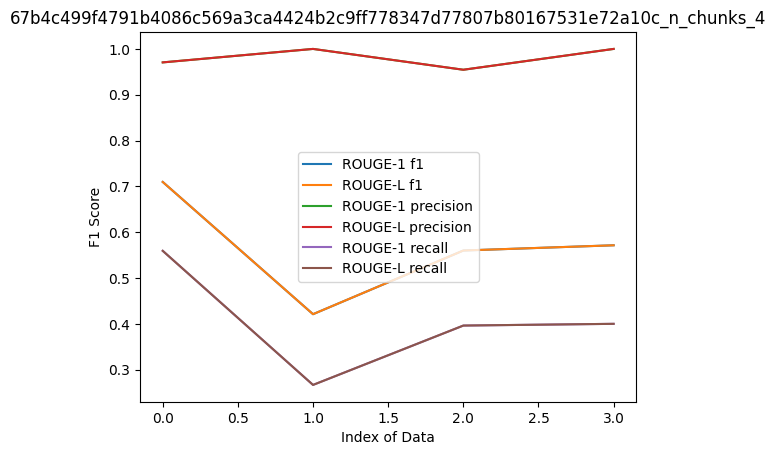

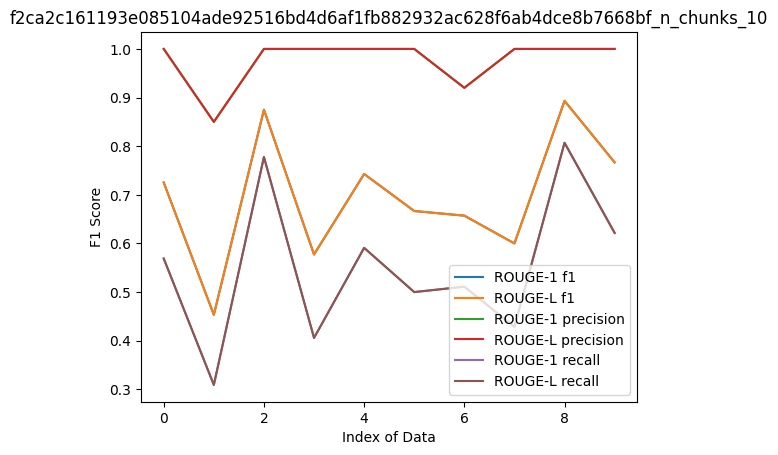

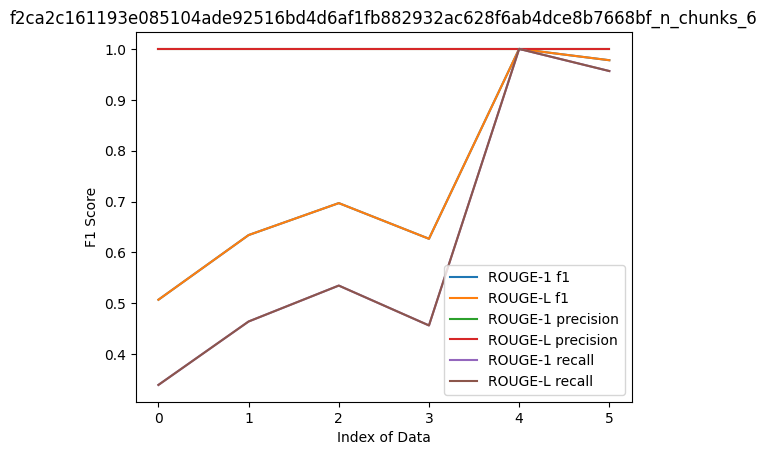

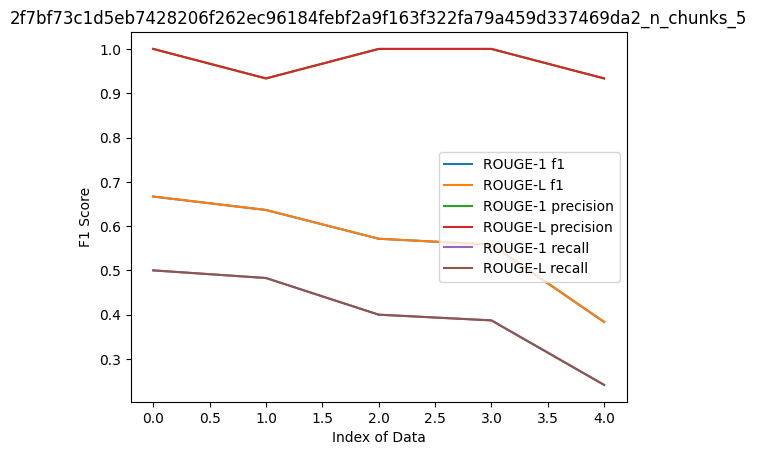

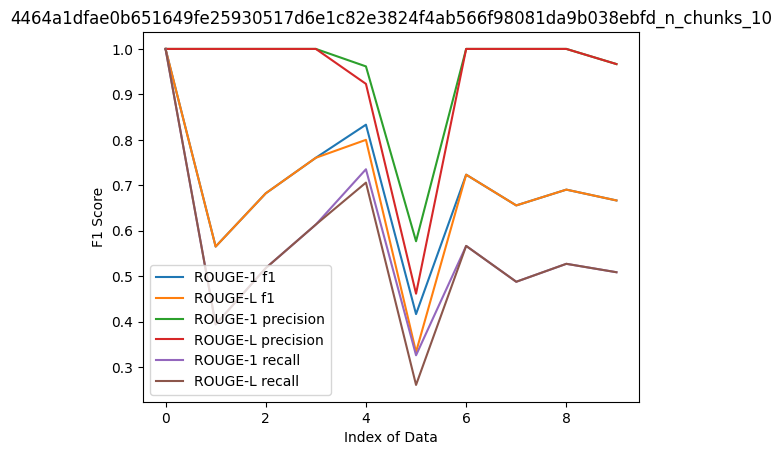

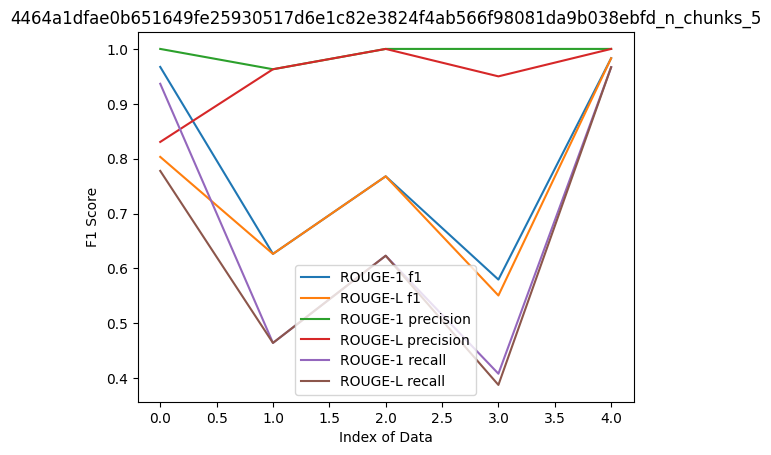

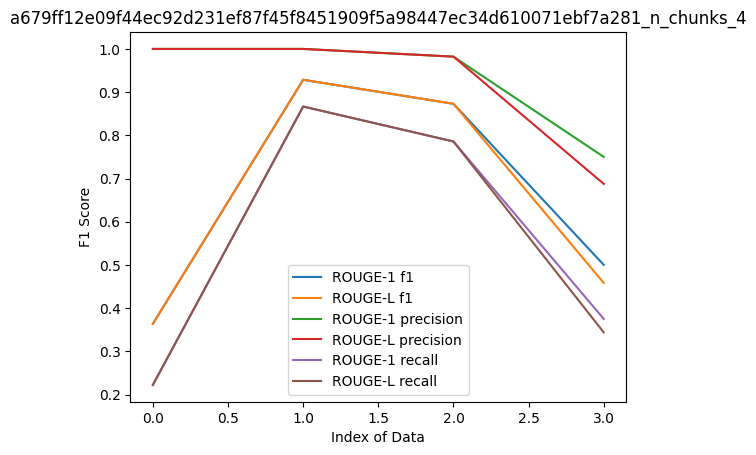

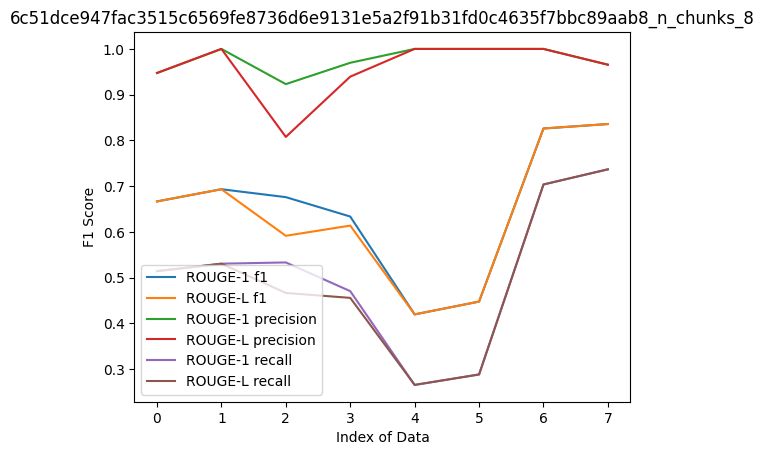

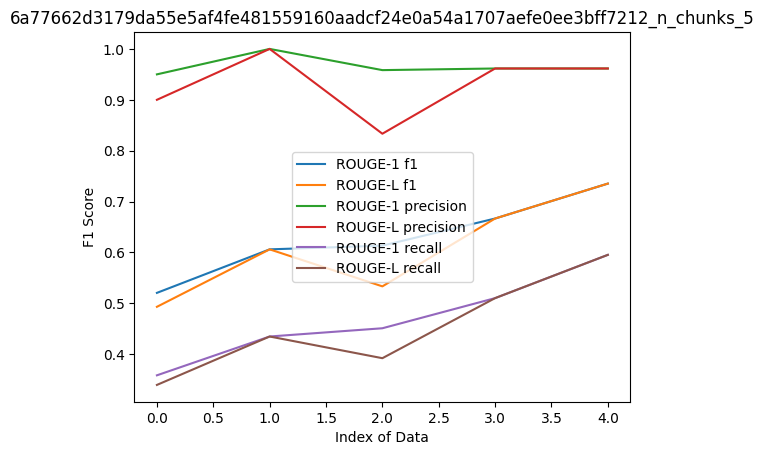

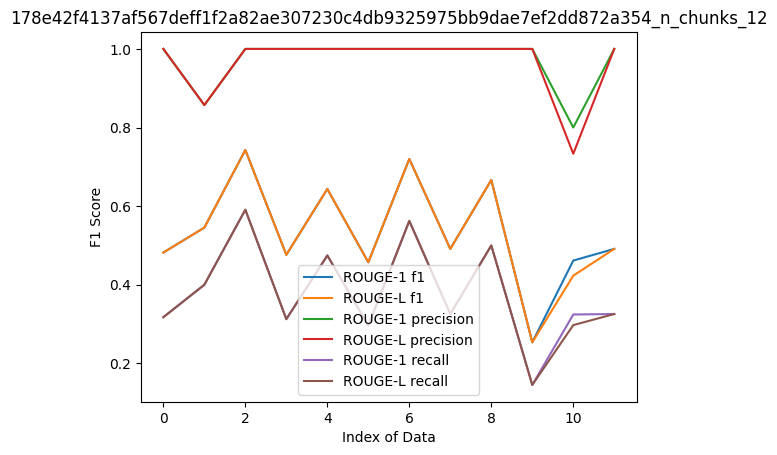

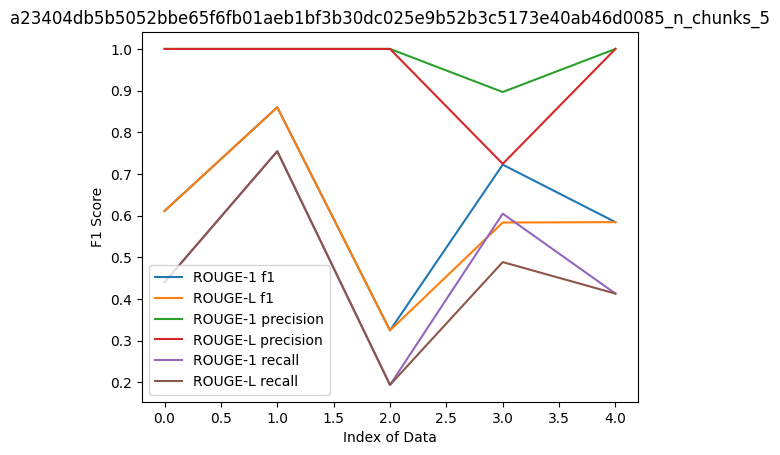

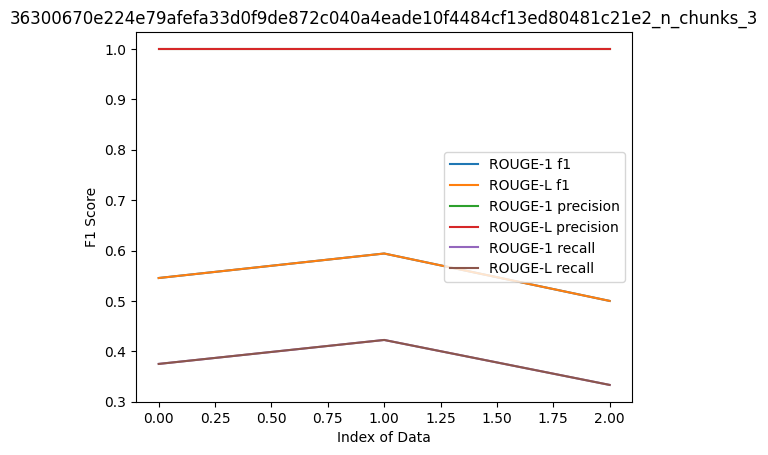

In [52]:
import matplotlib.pyplot as plt

# One experiment data

for e in experiment_results.keys():
  scores_data = experiment_results[e]['scores']

  f1_scores_rouge1 = [item['rouge1'].fmeasure for item in scores_data]
  f1_scores_rougeL = [item['rougeL'].fmeasure for item in scores_data]

  precision_scores_rouge1 = [item['rouge1'].precision for item in scores_data]
  precision_scores_rougeL = [item['rougeL'].precision for item in scores_data]

  recall_scores_rouge1 = [item['rouge1'].recall for item in scores_data]
  recall_scores_rougeL = [item['rougeL'].recall for item in scores_data]

  # Plotting the line plot
  index_values = list(range(len(scores_data)))

  plt.plot(index_values, f1_scores_rouge1, label='ROUGE-1 f1')
  plt.plot(index_values, f1_scores_rougeL, label='ROUGE-L f1')

  plt.plot(index_values, precision_scores_rouge1, label='ROUGE-1 precision')
  plt.plot(index_values, precision_scores_rougeL, label='ROUGE-L precision')

  plt.plot(index_values, recall_scores_rouge1, label='ROUGE-1 recall')
  plt.plot(index_values, recall_scores_rougeL, label='ROUGE-L recall')

  plt.xlabel('Index of Data')
  plt.ylabel('F1 Score')
  plt.title(e)
  plt.legend()
  plt.show()

- Seems like we could take the difference between scores and use that as a consistency/redundancy/quality measure.

In [58]:
values_chunk_numbers = []

values_meanf1_rouge1 = []
values_meanf1_rougeL = []

values_meanprecision_rouge1 = []
values_meanprecision_rougeL = []

values_meanrecall_rouge1 = []
values_meanrecall_rougeL = []

for e in experiment_results.keys():
  scores_data = experiment_results[e]['scores']
  n_chunks = int(e.split('_')[-1])

  values_chunk_numbers.append(n_chunks)

  # Get scores
  f1_scores_rouge1 = [item['rouge1'].fmeasure for item in scores_data]
  f1_scores_rougeL = [item['rougeL'].fmeasure for item in scores_data]

  precision_scores_rouge1 = [item['rouge1'].precision for item in scores_data]
  precision_scores_rougeL = [item['rougeL'].precision for item in scores_data]

  recall_scores_rouge1 = [item['rouge1'].recall for item in scores_data]
  recall_scores_rougeL = [item['rougeL'].recall for item in scores_data]

  # Mean scores
  meanf1_rouge1 = np.mean(f1_scores_rouge1)
  meanf1_rougeL = np.mean(f1_scores_rougeL)

  meanprecision_rouge1 = np.mean(precision_scores_rouge1)
  meanprecision_rougeL = np.mean(precision_scores_rougeL)

  meanrecall_rouge1 = np.mean(recall_scores_rouge1)
  meanrecall_rougeL = np.mean(recall_scores_rougeL)

  values_meanf1_rouge1.append(meanf1_rouge1)
  values_meanf1_rougeL.append(meanf1_rougeL)

  values_meanprecision_rouge1.append(meanprecision_rouge1)
  values_meanprecision_rougeL.append(meanprecision_rougeL)

  values_meanrecall_rouge1.append(meanrecall_rouge1)
  values_meanrecall_rougeL.append(meanrecall_rougeL)

df_values_plot = pd.DataFrame({'chunksize': values_chunk_numbers,
                               'meanf1_rouge1': values_meanf1_rouge1,
                               'meanf1_rougeL': values_meanf1_rougeL,
                               'meanprecision_rouge1': values_meanprecision_rouge1,
                               'meanprecision_rougeL': values_meanprecision_rougeL,
                               'meanrecall_rouge1': values_meanrecall_rouge1,
                               'meanrecall_rougeL': values_meanrecall_rougeL})

In [59]:
df_values_plot.sort_values(by='chunksize', inplace=True)

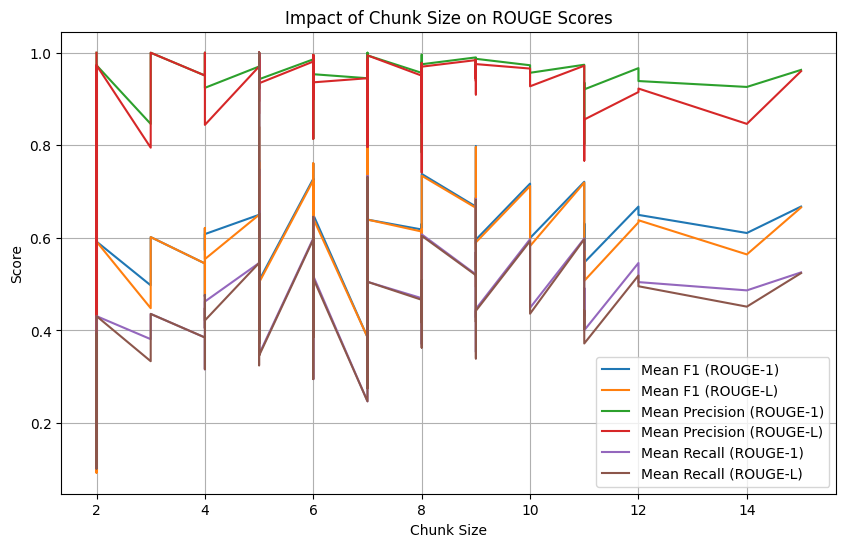

In [60]:
# Plotting
plt.figure(figsize=(10, 6))

plt.plot(df_values_plot['chunksize'], df_values_plot['meanf1_rouge1'], label='Mean F1 (ROUGE-1)')
plt.plot(df_values_plot['chunksize'], df_values_plot['meanf1_rougeL'], label='Mean F1 (ROUGE-L)')
plt.plot(df_values_plot['chunksize'], df_values_plot['meanprecision_rouge1'], label='Mean Precision (ROUGE-1)')
plt.plot(df_values_plot['chunksize'], df_values_plot['meanprecision_rougeL'], label='Mean Precision (ROUGE-L)')
plt.plot(df_values_plot['chunksize'], df_values_plot['meanrecall_rouge1'], label='Mean Recall (ROUGE-1)')
plt.plot(df_values_plot['chunksize'], df_values_plot['meanrecall_rougeL'], label='Mean Recall (ROUGE-L)')

plt.xlabel('Chunk Size')
plt.ylabel('Score')
plt.title('Impact of Chunk Size on ROUGE Scores')
plt.legend()
plt.grid(True)
plt.show()

In [57]:
# Now do with more data
#experiment_results = {}
#experimentSummaries(df.sample(300))
#More than 1 hour run didn't finish

KeyboardInterrupt: ignored

In [61]:
len(experiment_results)

89

In [63]:
df_values_plot.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 89 entries, 85 to 53
Data columns (total 7 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   chunksize             89 non-null     int64  
 1   meanf1_rouge1         89 non-null     float64
 2   meanf1_rougeL         89 non-null     float64
 3   meanprecision_rouge1  89 non-null     float64
 4   meanprecision_rougeL  89 non-null     float64
 5   meanrecall_rouge1     89 non-null     float64
 6   meanrecall_rougeL     89 non-null     float64
dtypes: float64(6), int64(1)
memory usage: 5.6 KB


In [62]:
df_values_plot.to_csv('exported_results_experiment.csv')

In [66]:
import json

with open("experiment_data.json", "w") as outfile:
    json.dump(experiment_results, outfile)


**A metric to evaluate the quality of the summaries**

- So far summaries are OK but there should be a sweet spot between max characters per bulletpoint and number of bulletpoints.


- Also to reduce redundancy. So maybe a good metric would be redundancy.